In [73]:
%matplotlib inline

import scipy.io
from scipy import optimize
import random
import numpy as np
import scipy.misc #Used to show matrix as an image
import matplotlib.pyplot as plt
import matplotlib.cm as cm #Used to display images in a specific colormap
from IPython.display import Image

#### 1.0 Loading data

In [74]:
data1 = scipy.io.loadmat('data/ex4data1')
data2 = scipy.io.loadmat('data/ex4weights')

#### 1.1 Defining functions for dealing with vectorized matrices (x,y must be vectorized for this to work)

In [75]:
# these are functions for flattening and rebuilding thetas (and also gradients)
num_features = 401
hidden_layer = 25
output_units = 10

'''
x is either a vectorized form of gradients or thetas, they are all the same in the end
'''
def split_and_reshape(x):
    x1 = x[0:num_features*hidden_layer]
    x1 = x1.reshape((hidden_layer,num_features))
    x2 = x[num_features*hidden_layer:num_features*hidden_layer+((hidden_layer+1)*output_units)]
    x2 = x2.reshape((output_units,hidden_layer+1))
    return x1,x2

def merge_and_flatten(x1,x2):
    x1 = x1.flatten()
    x2 = x2.flatten()
    y = np.append(x1,x2)
    return y

In [76]:
x = np.array(data1['X'])
x = np.insert(x,0,1,axis=1)
y = np.array(data1['y'])
theta1 = np.array(data2['Theta1']) #shape 25x401
theta2 = np.array(data2['Theta2']) #shape 10x26
thetas = merge_and_flatten(theta1,theta2)

#### 1.2 A small function for basic data visualization

In [77]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(x.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(x[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

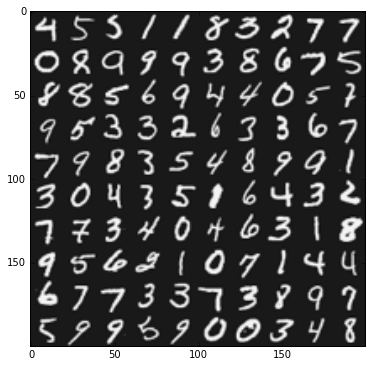

In [78]:
displayData()

#### 1.3 Defining sigmoid and sigmoid gradient function

In [79]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_gradient(x):
    return (sigmoid(x)*(1-sigmoid(x)))

def round(x):
    return (int(x>=0.5))

#### 1.4 Utility for randomly initializing values of theta

In [80]:
def init_theta(x,y):
    theta = np.random.rand(x,y)*2*0.12-0.12
    return theta

def drop_bias(theta):
    return theta[1:len(theta),:]

#### 1.5 Basic forward propagation algorithm

In [81]:
def  forward_propagate(x,thetas):
    theta1,theta2 = split_and_reshape(thetas)
    z2 = x.dot(theta1.T) #5000x401 X 401x25 = 5000x25
    a2 = sigmoid(z2)   #5000x25
    a2 = np.insert(a2,0,1,axis = 1)  # 5000x26
    z3 = a2.dot(theta2.T)  # 5000x26 X 26x10 = 5000x10
    a3 = sigmoid(z3) # 5000x10
    return z2,a2,z3,a3

To compute the cost we need to 
    - transform each y into a vector with 10 rows 
        -where only one row is marked with 1 ie the row of the index of digit

     - ie.  [6]
     - into [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]

In [82]:
def transform_to_vector(y):
    y_new = np.zeros((len(y),10))
    for i in range (len(y)):
        num = y[i,0]
        y_new[i,num-1] = 1 
    return y_new
y_new = transform_to_vector(y)
print(y_new[3000])
print(y[3000])

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[6]


#### 1.6 Definining the regularized and non-regularized cost_function

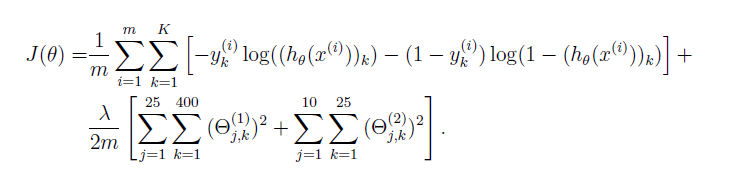

In [83]:
Image(filename='data/cost_function.png')

In [84]:
def cost_function(thetas,x,y):
    theta1,theta2 = split_and_reshape(thetas)
    m = len(x)
    z2,a2,z3,a3 = forward_propagate(x,thetas)
    h=a3
    left = 0
    right = 0
    for i in range(len(h)):
        left += y[i,:].dot(np.log(h[i,:]).T)
        right += (1-y)[i,:].dot(np.log(1-h[i,:]).T)
    total_cost = (-1) * (left+right) / m
    return total_cost
    
def cost_function_regularized(thetas,x,y,lambda_val):
    m = len(x)
    normal_cost = cost_function(thetas,x,y)
    theta_cost1 = (drop_bias(theta1)**2).sum()
    theta_cost2 = (drop_bias(theta2)**2).sum()
    theta_sum = theta_cost1 + theta_cost2
    regularization_cost = (lambda_val/(2*m))*theta_sum
    total_cost = normal_cost + regularization_cost
    return total_cost

In [85]:
cost_function(thetas,x,y_new)

0.28762916516131937

In [86]:
cost_function_regularized(thetas,x,y_new,1)

0.37904640005669221

### 2. Backpropagation algorithm

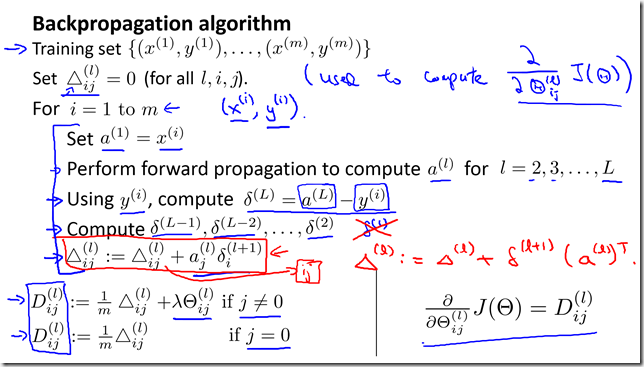

In [87]:
Image(filename='data/backprop_algo.png')

In [88]:
def backprop(thetas,x,y):
    vsigmoid_grad = np.vectorize(sigmoid_gradient)  
    theta1,theta2 = split_and_reshape(thetas)
    # theta1 - 25x401
    # theta2 - 10x26
    # delta1 and delta2 need to be the size of theta1 and theta2
    delta1 = np.zeros((len(theta1),len(theta1[0]))) #25x401
    delta2 = np.zeros((len(theta2),len(theta2[0]))) #10x26
    m = len(x)
    for i in range(len(x)):
        a1 = np.matrix(x[i]) # 1x401
        z2,a2,z3,a3 = forward_propagate(np.matrix(x[i]),thetas)
        #z2 - 1x25, a2 - 1x26, z3 - 1x10, a3 - 1x10
        error3 = (a3 - y[i]).T #1x10
        error2 = np.multiply(theta2.T[1:,:].dot(error3).flatten(),vsigmoid_grad(z2)).T  # (25x10 X 10x1) * (25x1)
        delta1 += error2.dot(a1) #25x1 X 1x401 = 25x401
        delta2 += error3.dot(a2) #10x1 X 1x26 = 10x26
    D1 = delta1/m
    D2 = delta2/m
    ds = merge_and_flatten(D1,D2)
    return ds

#### 2.1 Gradient checking algorithm

In [89]:
j=random.randint(0,len(thetas)-1)

def gradient_check(j):
    e = 0.001
    thetas1 = thetas.copy()
    thetas1[j] += e
    thetas2 = thetas.copy() #here you must do a copy() to get rid of pass by reference
    thetas2[j] -= e
    val = (cost_function(thetas1,x,y_new)-cost_function(thetas2,x,y_new))/float(2*e)
    return val

gradient_check_val = gradient_check(j)
back_prop_vals= backprop(thetas,x,y_new)
computed_gradient_value = back_prop_vals[j]
print('gradient check value %f.'%gradient_check_val)
print('computed gradient value %f.'%computed_gradient_value)


gradient check value -0.000173.
computed gradient value -0.000173.


#### 2.2 Algorithm for cleaning the results
- Params: X - input data
          theta - parameters for solving
- results are in 5000x10 format, so we clean them by just taking the column with highest probabilities index

In [90]:
def predictNN(x,thetas):
    z2,a2,z3,a3 = forward_propagate(x,thetas)
    best = np.argmax(a3,axis = 1)+1
    return best

#### 2.3 Using gradient descent for optimization (unsuccessfully)

In [58]:
iterations = 5
learning_rate = 0.001
theta1f = init_theta(len(theta1),len(theta1[0]))
theta2f = init_theta(len(theta2),len(theta2[0]))
thetas2f = merge_and_flatten(theta1f,theta2f)

for i in range(iterations):
    print(i,end=' ')
    thetas2f = thetas2f -learning_rate*backprop(thetas,x,y_new)

0 (10285,)
1 (10285,)
2 (10285,)
3 (10285,)
4 (10285,)


In [60]:
sol = predictNN(x,thetas2f)
print('In total, Training set accuracy: {} %'.format(np.mean(sol == y.ravel())*100))

In total, Training set accuracy: 10.02 %


## 3. fmin_cg for optimization (scipy.optimize library)

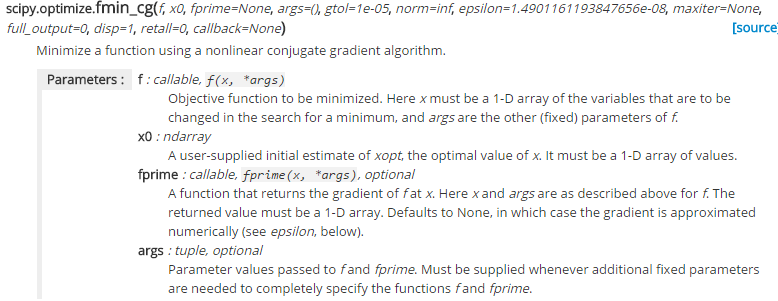

In [91]:
Image(filename='data/optimize.png')

- our function call looks as 
result = optimize.fmin_cg(cost_function, x0=thetas2f, fprime=backprop,args=(x,y_new),maxiter=50,disp=True,full_output=True)

- the default one is 
scipy.optimize.fmin_cg(f, x0, fprime=None, args=(), gtol=1e-05, norm=inf, epsilon=1.4901161193847656e-08, maxiter=None, full_output=0, disp=1, retall=0, callback=None

    - to explain it
        - first param is the cost function we wish to minimize
        - second param is the x0 parameter which we want to change, in our case that is thetas but in vector form 
            - remember we have to transform it from eg 401x25 format to 10025x1, 
               and then inside the function we can reshape it back into 401x25
        - third param is the fprime function ie the gradient which we will use
        - 4th are arguments for both cost function and the gradient function
            this is the tricky part since the first argument to both functions will be supplied with x0, 
             all other arguments must be supplied in the order they are used in both cost and gradient functions
                  -so if we defined it as: def cost_function(thetas,x,y): 
                     -then we already have x0=thetas, we must just supply args=(x,y)
        - 5th argument is the maximal number of iterations
        - 6th and 7th are the shape of our return function

#### Getting the results from optimization
  - 1 min, 5min and 20min version

In [94]:
'''
This is the result with 50 iterations - 95.72% accuracy
- it takes around 5mins to perform this
'''
iterations = 5
thetas_rand = init_theta(len(thetas),1)
result = optimize.fmin_cg(cost_function, x0=thetas_rand, fprime=backprop,args=(x,y_new),maxiter=iterations,disp=True,full_output=True)
sol2 = predictNN(x,result[0])
print('In total, Training set accuracy: {} %'.format(np.mean(sol2 == y.flatten())*100))

         Current function value: 2.603395
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
In total, Training set accuracy: 33.92 %


In [95]:
'''
This is the result with 50 iterations - 95.72% accuracy
- it takes around 5mins to perform this
'''
iterations = 50
thetas_rand = init_theta(len(thetas),1)
result = optimize.fmin_cg(cost_function, x0=thetas_rand, fprime=backprop,args=(x,y_new),maxiter=iterations,disp=True,full_output=True)
sol2 = predictNN(x,result[0])
print('In total, Training set accuracy: {} %'.format(np.mean(sol2 == y.flatten())*100))

         Current function value: 0.262028
         Iterations: 50
         Function evaluations: 114
         Gradient evaluations: 114
In total, Training set accuracy: 96.89999999999999 %


In [ ]:
'''
This is the result with 200 iterations - 100%
- it takes around 20mins to finish this
'''
iterations = 200
thetas_rand = init_theta(len(thetas),1)
result = optimize.fmin_cg(cost_function, x0=thetas_rand, fprime=backprop,args=(x,y_new),maxiter=iterations,disp=True,full_output=True)
sol2 = predictNN(x,result[0])
print('In total, Training set accuracy: {} %'.format(np.mean(sol2 == y.flatten())*100))